In [71]:


## Import Python libraries


import pandas as pd



import numpy as np



import matplotlib.pyplot as plt



import seaborn as sns



from sklearn.compose import ColumnTransformer



from sklearn.pipeline import make_pipeline



from sklearn.preprocessing import(
    
    
    
    FunctionTransformer,
    
    

    
    StandardScaler
    
    
)




from sklearn.model_selection import train_test_split




from sklearn.pipeline import Pipeline



from sklearn.model_selection import  KFold





This Python code trains a Poisson generalized linear model (GLM) with regularization




We use this model as a baseline model and for feature selection



We use the selected features in the next modelling stage to improve lung cancer prevalence prediction



Before training the model, we will highlight the model settings





## Poisson GLM with regularization




We model count data $Y_{i}$ under the assumption:

\begin{align}
\mathbb{E}[Y_{i}] = A_{i} \lambda_{i},
\end{align}
where

\begin{align}
\lambda_i  = e^{\mathbf{x}_{i}^\top \boldsymbol{\beta}}
\end{align}


Here, $A_{i}$ denotes the size of a given region, $\lambda_{i}$ is the intensity of events occurring within the area $A_{i}$, $\mathbf{x}_i$ is a $p \times 1$ vector of observed features, and $\boldsymbol{\beta}$ is a $p \times 1$ vector of parameters



In our case, $A_{i} = N_{i}$ represents the total population size, and $\lambda_i$ denotes the incidence rate of lung cancer per person in that population



The Poisson probability mass function is



\begin{align}
P(Y_{i} = y_{i}) & = \frac{(N_{i} \lambda_{i})^{y_{i}} e^{-N_{i} \lambda_{i}}}{y_{i}!}\\
&= \frac{\left(N_{i} e^{\mathbf{x}_{i}^\top \boldsymbol{\beta}} \right)^{y_{i}} e^{-N_{i} e^{\mathbf{x}_{i}^\top \boldsymbol{\beta}}}}{y_{i}!}
\end{align}



We assume that $y_{1}$, $y_{2}$, $\cdots$, $y_{n}$ are independent observations. The log-likelihood over the $n$ observations can be given by


\begin{align}
\ell(\boldsymbol{\beta}) = \sum_{i=1}^n \left[
y_{i} \log N_{i} + y_{i} \mathbf{x}_{i}^\top \boldsymbol{\beta}
- N_{i} e^{\mathbf{x}_{i}^\top \boldsymbol{\beta}} - \log(y_{i}!)
\right]
\end{align}



## Regularization


Let $\alpha \ge 0$ and $\gamma \ge 0$.



$L_{2}$ penalty (Ridge regression)


\begin{align}
Penalty = \frac{\alpha}{2} \|\boldsymbol{\beta}\|_2^2
\end{align}
  
$L_{1}$ penalty (Lasso regression)

\begin{align}
Penalty = \alpha \|\boldsymbol{\beta}\|_1
\end{align}
  
$L_{1}$ plus $L_{2}$ penalty (Elastic Net Penalty)


\begin{align}
Penalty = \alpha \left[ \gamma \|\boldsymbol{\beta}\|_1 + \frac{1 - \gamma}{2} \|\boldsymbol{\beta}\|_2^2 \right]
\end{align}


## Objective Function

Next, we minimize the regularized loss function given by

\begin{align}
\mathcal{L}(\boldsymbol\beta) = - \ell(\boldsymbol\beta) + \text{Penalty}
\end{align}

Using Elastic Net penalty regularization, the regularized loss function is given by

\begin{align}
\mathcal{L}(\boldsymbol{\beta}) = - \sum_{i=1}^n \left[y_{i} \log N_{i} + y_{i} \mathbf{x}_{i}^\top \boldsymbol{\beta} - N_{i} e^{\mathbf{x}_{i}^\top \boldsymbol{\beta}} - \log(y_{i}!) \right] + \alpha \left[ \gamma \|\boldsymbol{\beta}\|_1 + \frac{1 - \gamma}{2} \|\boldsymbol{\beta}\|_2^2 \right]
\end{align}




    

In [72]:


## Read data




x = pd.read_csv('../Data/xdata.csv')

         


y = pd.read_csv('../Data/ydata.csv')


         

N = pd.read_csv('../Data/Ndata.csv')




         

In [73]:


x.head()



,Pct_Civilian_Unemployed,Pct_BelowPoverty_18andOver,Pct_Population_Male_65andOver,Pct_Population_Female_65andOver,Pct_Black_65andOver,Pct_Black_Male_65andOver,Pct_Black_Female_65andOver,Pct_White_65andOver,Pct_White_Male_65andOver,Pct_White_Female_65andOver,...,OBESITY_CrudePrev,Median_Household_Income,ZCTA_pm2_5,sdi_score,Pct_White_Male_Between18and65,Pct_White_Female_Between18and65,Pct_Black_Female_Between18and65,Pct_Black_Male_Between18and65,Pct_Hisp_Male_Between18and65,Pct_Hisp_Female_Between18and65
0,2.3,1.907688,4.801372,4.222635,0.685910,0.278651,0.407259,4.779937,2.657902,2.122035,...,22.5,153314.0,7.801598,1.0,24.242641,24.607031,5.487282,4.965704,3.801086,3.772506
1,4.6,12.441946,13.664141,13.101931,0.562210,0.562210,0.000000,25.054999,12.784160,12.270838,...,32.2,82500.0,7.171176,18.0,32.437057,34.685896,1.613297,1.124419,0.024444,2.371058
2,4.5,9.415209,3.328926,5.630699,1.247500,0.420353,0.827147,5.800197,2.108546,3.691651,...,36.6,70629.0,7.940322,72.0,27.329740,25.495780,7.922302,7.573138,17.732805,16.149700
3,5.6,7.276174,5.479870,6.820011,1.459449,0.638162,0.821287,9.725035,4.242391,5.482645,...,31.7,81042.0,8.013779,50.0,29.014178,28.844927,5.651896,7.497017,14.896923,13.226603
4,5.6,8.663903,5.480546,6.089073,1.361579,0.893774,0.467805,8.739969,3.966835,4.773134,...,33.8,88207.0,8.080360,56.0,31.129959,29.057164,3.822310,4.446050,17.616856,14.152056


In [74]:


y.head()



,case_n_18plus
0,15.0
1,21.0
2,68.0
3,102.0
4,66.0


In [75]:



N.head()



,Population_18andOver
0,13996
1,4091
2,29499
3,36041
4,26293


In [76]:



## Split the data into a training set (70%) and a test set (30%)



## Set random seed




x_train, x_test, y_train, y_test, N_train, N_test = train_test_split(x, y, N, test_size = 0.3, random_state = 420)





In [77]:



print("Train data")


print(y_train.shape)


print(x_train.shape)


print(N_train.shape)



print("Test data")


print(y_test.shape)


print(x_test.shape)


print(N_test.shape)



Train data
(551, 1)
(551, 25)
(551, 1)
Test data
(237, 1)
(237, 25)
(237, 1)


In [78]:


## Transform the features




In [79]:


xtrain = x_train.copy(deep = True)



xtest = x_test.copy(deep = True)



# Apply Percent2DecimalTransformer



percent_columns = ["Pct_Civilian_Unemployed", "Pct_BelowPoverty_18andOver",
    
    
    "Pct_Population_Male_65andOver", "Pct_Population_Female_65andOver",
                   
                   
    "Pct_Black_65andOver", "Pct_Black_Male_65andOver", "Pct_Black_Female_65andOver",
                   
                   
                   
    "Pct_White_65andOver", "Pct_White_Male_65andOver", "Pct_White_Female_65andOver",
                   
                   
                   
    "Pct_Hisp_65andOver", "Pct_Hisp_Male_65andOver", "Pct_Hisp_Female_65andOver",
                   
                   
    "Pct_White_Male_Between18and65", "Pct_White_Female_Between18and65",
                   
                   
                   
    "Pct_Black_Female_Between18and65", "Pct_Black_Male_Between18and65",
                   
                   
                   
    "Pct_Hisp_Male_Between18and65", "Pct_Hisp_Female_Between18and65"
                   
                   
]


xtrain[percent_columns] = xtrain[percent_columns] / 100





# Apply StandardScaleTransformer



scale_columns = ["BINGE_CrudePrev", 
                 
                 
                 "CSMOKING_CrudePrev", 
                 
                 
                 
                 "OBESITY_CrudePrev",
                 
                 
                 
                 "Median_Household_Income", 
                 
                 
                 
                 "ZCTA_pm2_5", 
                 
                 
                 
                 "sdi_score"]



scaler = StandardScaler()



# Fit and transform the training data


xtrain[scale_columns] = scaler.fit_transform(xtrain[scale_columns])



# Apply the same transformation to the test data (using the learned parameters)


xtest[scale_columns] = scaler.transform(xtest[scale_columns])




xtest[percent_columns] = xtest[percent_columns] / 100




In [80]:


xtrain.head()



,Pct_Civilian_Unemployed,Pct_BelowPoverty_18andOver,Pct_Population_Male_65andOver,Pct_Population_Female_65andOver,Pct_Black_65andOver,Pct_Black_Male_65andOver,Pct_Black_Female_65andOver,Pct_White_65andOver,Pct_White_Male_65andOver,Pct_White_Female_65andOver,...,OBESITY_CrudePrev,Median_Household_Income,ZCTA_pm2_5,sdi_score,Pct_White_Male_Between18and65,Pct_White_Female_Between18and65,Pct_Black_Female_Between18and65,Pct_Black_Male_Between18and65,Pct_Hisp_Male_Between18and65,Pct_Hisp_Female_Between18and65
128,0.081,0.109459,0.099546,0.077654,0.036349,0.036349,0.000000,0.130525,0.056175,0.074349,...,0.536559,-0.096117,-0.021411,0.287624,0.381660,0.355638,0.036349,0.029740,0.007848,0.019827
685,0.021,0.054880,0.133146,0.150608,0.000000,0.000000,0.000000,0.283754,0.133146,0.150608,...,-0.181072,0.169842,-1.713352,-1.174760,0.380730,0.326162,0.000624,0.002183,0.000935,0.000000
405,0.037,0.046646,0.091463,0.101220,0.004268,0.000000,0.004268,0.188415,0.091463,0.096951,...,-0.480085,0.586360,-2.000604,-1.300107,0.389024,0.356098,0.016159,0.007927,0.008537,0.010671
226,0.045,0.276737,0.052392,0.070187,0.018991,0.006709,0.012281,0.098396,0.044662,0.053734,...,-1.496730,-0.034168,-0.621242,1.206836,0.313419,0.308460,0.063244,0.056330,0.025146,0.014819
43,0.018,0.082286,0.156000,0.163429,0.033714,0.000000,0.033714,0.278286,0.148571,0.129714,...,-0.639559,0.661640,-0.268954,-0.882283,0.300571,0.370286,0.000000,0.000000,0.060571,0.049714


In [81]:


xtest.head()



,Pct_Civilian_Unemployed,Pct_BelowPoverty_18andOver,Pct_Population_Male_65andOver,Pct_Population_Female_65andOver,Pct_Black_65andOver,Pct_Black_Male_65andOver,Pct_Black_Female_65andOver,Pct_White_65andOver,Pct_White_Male_65andOver,Pct_White_Female_65andOver,...,OBESITY_CrudePrev,Median_Household_Income,ZCTA_pm2_5,sdi_score,Pct_White_Male_Between18and65,Pct_White_Female_Between18and65,Pct_Black_Female_Between18and65,Pct_Black_Male_Between18and65,Pct_Hisp_Male_Between18and65,Pct_Hisp_Female_Between18and65
503,0.018,0.111885,0.205370,0.180507,0.045748,0.023371,0.022377,0.337643,0.181999,0.155644,...,0.516625,-0.396132,0.790328,-0.589806,0.227747,0.281949,0.041273,0.054699,0.004475,0.000000
283,0.000,0.140559,0.157343,0.165035,0.087413,0.061538,0.025874,0.234965,0.095804,0.139161,...,0.257480,-0.146293,-0.122334,-0.380895,0.283217,0.300699,0.036364,0.057343,0.000000,0.000000
570,0.060,0.114497,0.167487,0.146291,0.005299,0.005299,0.000000,0.297123,0.162188,0.134936,...,0.117941,0.052139,0.015012,-0.589806,0.321726,0.335352,0.013248,0.007949,0.000000,0.000000
362,0.039,0.143308,0.131819,0.151205,0.079202,0.029355,0.049848,0.200222,0.101357,0.098865,...,1.632941,-0.738895,-1.794047,1.123271,0.228469,0.266131,0.101080,0.103019,0.044032,0.039047
541,0.108,0.192024,0.137857,0.150831,0.027067,0.014934,0.012134,0.260687,0.122923,0.137764,...,0.636230,-0.992627,0.183412,1.248618,0.282901,0.306795,0.047415,0.034908,0.017174,0.018761




## Cross-validation





We used elastic net regularization



The ridge–lasso mixing weight is hand-picked



The regularization parameter is selected via five-fold cross-validation




In [150]:

# Regularization settings


# Lasso: L1_wt = 1


# Elastic net: 0 < L1_wt < 1 



# Alpha  varies



L1wt = 0.25  # Elastic net 



# Generate a range of alpha values for the regularization

    

alpha_values = np.logspace(-3.5, 0.5, 100)



# K-Fold Cross-Validation



kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)



# Store results



coefficients = []



mae_scores = []



# Loop through different alpha values

    
for alpha in alpha_values:
    
    
    fold_mae_scores = []
    
    
    fold_coefficients = []
    
    
    
    for fold, (train_index, val_index) in enumerate(kfold.split(xtrain), 1):
        
        
        
        trainx, valx = xtrain.iloc[train_index], xtrain.iloc[val_index]
        
        
        
        trainy, valy = y_train.iloc[train_index], y_train.iloc[val_index]
        
        
        
        trainN, valN = N_train.iloc[train_index], N_train.iloc[val_index]
        

        # Fit Poisson GLM with regularization and offset
        
        
        
        glm_poisson = sm.GLM(trainy, sm.add_constant(trainx),
                             
                             
                             family = sm.families.Poisson(),
                             
                             
                             offset = np.log(trainN.squeeze()))

        
        
        result = glm_poisson.fit_regularized(method = 'elastic_net',
                                             

                                             
                                             alpha = alpha,
                                             
                                             
                                             
                                              maxiter = 3*(10**4),
                                             
                                             
                                             
                                             L1_wt = L1wt)  
        
        # Coefficients
        
        
        coef = result.params
        
        
        fold_coefficients.append(coef)
        
        

        # Predict on validation set
        
        
        predy = result.predict(sm.add_constant(valx), offset = np.log(valN.squeeze()))
        
            
        

        # Calculate MAE
        
        
        mae = np.mean(np.abs(valy.squeeze() - predy.squeeze()))
        
        
        fold_mae_scores.append(mae)
        
        

    # Average Mae for this alpha
    
    
    
    mae_scores.append(np.mean(fold_mae_scores))
    
    

    coefficients.append(np.mean(fold_coefficients, axis=0))
    
    

# Find the alpha with the lowest average Mae


best_alpha_idx = np.argmin(mae_scores)



best_alpha = alpha_values[best_alpha_idx]



best_mae = mae_scores[best_alpha_idx]




print("\nBest Alpha:", best_alpha)



print("Best Mae:", best_mae)



# Average Coefficients for best alpha



best_coefficients = coefficients[best_alpha_idx]



print("Average Coefficients for Best Alpha:", best_coefficients)




Best Alpha: 0.0010598698188825015
Best Mae: 6.238941024560155
Average Coefficients for Best Alpha: [-6.29446269e+00  5.08825799e-02 -1.32907789e+00  1.08782099e+00
  2.07018445e+00  2.58456643e+00  0.00000000e+00  0.00000000e+00
  8.12905195e-01  1.93469085e-01  9.65056034e-02 -7.89522584e-01
  0.00000000e+00 -1.81020532e+00 -2.78659947e-03  1.26189852e-01
  4.74685233e-02 -8.15466057e-02 -6.75315260e-02  3.64216511e-02
  7.48676016e-01  1.11221881e+00  9.45756854e-01 -3.73599536e-02
 -4.87912483e-01 -1.25496142e+00]


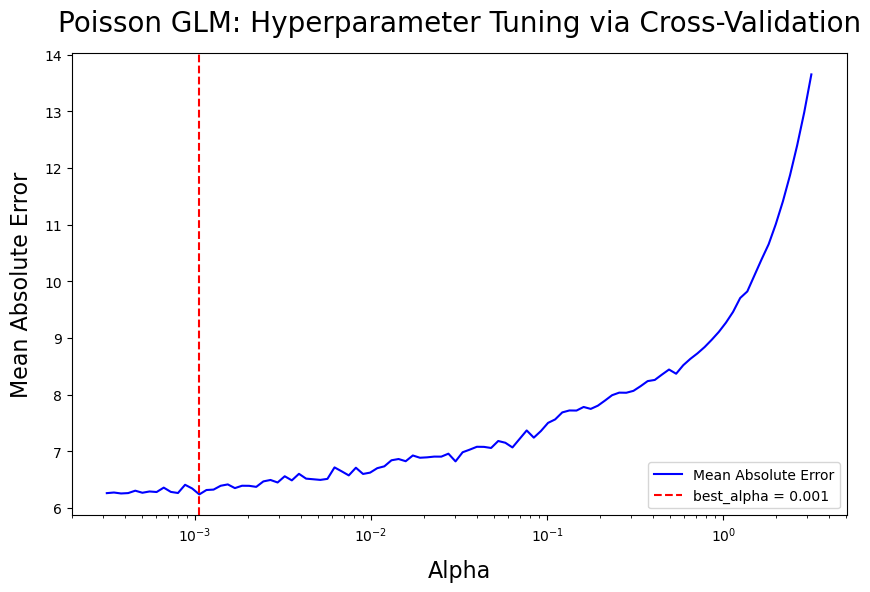

In [198]:


# Plot mean absolute value of coefficients against alpha




plt.figure(figsize = (10, 6))



plt.plot(alpha_values,   mae_scores, label = 'Mean Absolute Error', color = 'blue')



plt.axvline(best_alpha, color = 'red', linestyle = '--', label = f'best_alpha = {best_alpha:.3f}')



plt.xscale('log')



plt.xlabel('Alpha', fontsize = 16, labelpad = 11)



plt.ylabel('Mean Absolute Error', fontsize = 16, labelpad = 8)



plt.title("Poisson GLM: Hyperparameter Tuning via Cross-Validation", fontsize = 20, pad = 16)



plt.grid(False)



plt.legend()



plt.savefig('../Results/cross_validation_pglm.png', dpi = 300)



plt.show()




In [114]:


## Is the optimal alpha estimate the lowest of the candidates?



alpha_values



array([3.16227766e-04, 3.47059583e-04, 3.80897464e-04, 4.18034496e-04,
       4.58792343e-04, 5.03524031e-04, 5.52617002e-04, 6.06496477e-04,
       6.65629135e-04, 7.30527154e-04, 8.01752650e-04, 8.79922544e-04,
       9.65713905e-04, 1.05986982e-03, 1.16320582e-03, 1.27661695e-03,
       1.40108553e-03, 1.53768963e-03, 1.68761248e-03, 1.85215261e-03,
       2.03273520e-03, 2.23092437e-03, 2.44843675e-03, 2.68715631e-03,
       2.94915073e-03, 3.23668929e-03, 3.55226249e-03, 3.89860370e-03,
       4.27871275e-03, 4.69588196e-03, 5.15372466e-03, 5.65620645e-03,
       6.20767959e-03, 6.81292069e-03, 7.47717205e-03, 8.20618709e-03,
       9.00628020e-03, 9.88438140e-03, 1.08480964e-02, 1.19057724e-02,
       1.30665705e-02, 1.43405450e-02, 1.57387304e-02, 1.72732372e-02,
       1.89573565e-02, 2.08056754e-02, 2.28342030e-02, 2.50605097e-02,
       2.75038784e-02, 3.01854726e-02, 3.31285189e-02, 3.63585086e-02,
       3.99034183e-02, 4.37939523e-02, 4.80638086e-02, 5.27499706e-02,
      

In [152]:


# Save the results, as training takes time



pd.DataFrame([{'best_alpha_glm': best_alpha}]).to_csv('../Results/best_alpha_glm.csv', index = False)



pd.DataFrame([{'best_mae_glm': best_mae}]).to_csv('../Results/best_mae_glm.csv', index = False)



pd.DataFrame([{'best_coefficients_glm': best_coefficients}]).to_csv('../Results/best_coefficients_glm.csv', index = False)



pd.DataFrame([{'gamma_glm': L1wt}]).to_csv('../Results/gamma_glm.csv', index = False)


pd.DataFrame([{'alpha_values_glm': alpha_values}]).to_csv('../Results/alpha_values_glm.csv', index = False)



pd.DataFrame([{'mae_scores_glm': mae_scores}]).to_csv('../Results/mae_scores_glm.csv', index = False)





In [119]:


best_alpha



0.0010598698188825015

In [120]:

 L1_wt


0.25

Next, we fit the model to the training data using the selected hyperparameter $\alpha = 0.0011$ and the hand-picked elastic net parameter, $\gamma = 0.25$


In [191]:


glm_poisson = sm.GLM(y_train, sm.add_constant(xtrain),
                             
                             
                             family = sm.families.Poisson(),
                             
                             
                             offset = np.log(N_train.squeeze()))

        
        
result = glm_poisson.fit_regularized(method = 'elastic_net',
                                             
                                             
                                             alpha = best_alpha,
                                             
                                             
                                             
                                              maxiter = 10000,
                                             
                                             
                                     
                                              opt_method = 'str',
                                     
                                     
                                             
                                             L1_wt =  L1_wt)  
        
        
coef = result.params 



coef
     
    

const                             -6.505967
Pct_Civilian_Unemployed            0.000000
Pct_BelowPoverty_18andOver        -1.338841
Pct_Population_Male_65andOver      2.797313
Pct_Population_Female_65andOver    2.743481
Pct_Black_65andOver                0.000000
Pct_Black_Male_65andOver           0.000000
Pct_Black_Female_65andOver         2.487065
Pct_White_65andOver                0.135896
Pct_White_Male_65andOver          -0.484058
Pct_White_Female_65andOver         0.000000
Pct_Hisp_65andOver                -0.885328
Pct_Hisp_Male_65andOver            0.000000
Pct_Hisp_Female_65andOver         -1.818826
BINGE_CrudePrev                   -0.017242
CSMOKING_CrudePrev                 0.124637
OBESITY_CrudePrev                  0.039213
Median_Household_Income           -0.086541
ZCTA_pm2_5                        -0.069284
sdi_score                          0.033822
Pct_White_Male_Between18and65      1.085857
Pct_White_Female_Between18and65    1.295837
Pct_Black_Female_Between18and65 

In [196]:

# Predict on test data set
   
    
        
predy = result.predict(sm.add_constant(xtest), offset = np.log(N_test.squeeze()))
        
            
        

# Calculate MAE
        
  
        
mae = np.mean(np.abs(y_test.squeeze() - predy.squeeze()))
        

    
mae



6.312945863119008

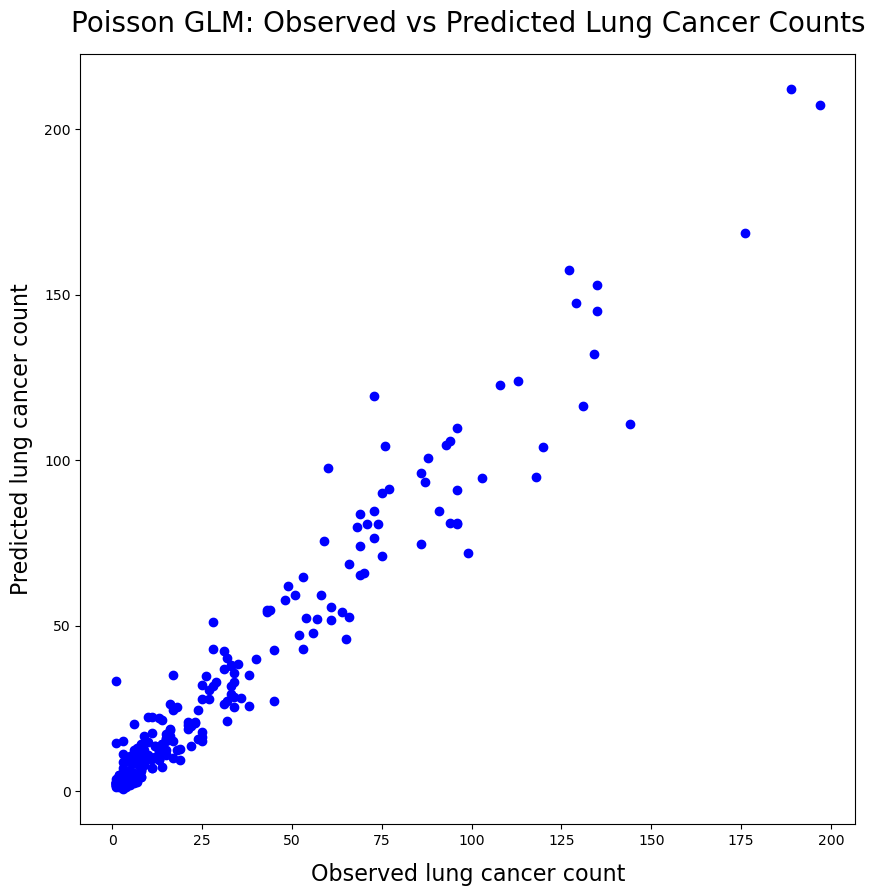

In [199]:



# Plot the test response values (test data)  against the predicted response values


# That is, observed lung cancer count (test data) vs predicted lung caner count




plt.figure(figsize = (10, 10))



plt.scatter(y_test,   predy,  color = 'blue')



plt.xlabel('Observed lung cancer count', fontsize = 16,  labelpad=11)



plt.ylabel('Predicted lung cancer count', fontsize = 16, labelpad=8)


plt.title('Poisson GLM: Observed vs Predicted Lung Cancer Counts',fontsize = 20,  pad=16) 


plt.grid(False)



plt.savefig('../Results/ytestypredictpglm.png', dpi = 300)



plt.show()






Next, we exclude the features with zero estimated coefficients to further investigate the incidence rate of lung cancer




In [148]:

non_zero_coef = coef[coef != 0]


non_zero_coef


const                             -6.505967
Pct_BelowPoverty_18andOver        -1.338841
Pct_Population_Male_65andOver      2.797313
Pct_Population_Female_65andOver    2.743481
Pct_Black_Female_65andOver         2.487065
Pct_White_65andOver                0.135896
Pct_White_Male_65andOver          -0.484058
Pct_Hisp_65andOver                -0.885328
Pct_Hisp_Female_65andOver         -1.818826
BINGE_CrudePrev                   -0.017242
CSMOKING_CrudePrev                 0.124637
OBESITY_CrudePrev                  0.039213
Median_Household_Income           -0.086541
ZCTA_pm2_5                        -0.069284
sdi_score                          0.033822
Pct_White_Male_Between18and65      1.085857
Pct_White_Female_Between18and65    1.295837
Pct_Black_Female_Between18and65    1.433959
Pct_Hisp_Male_Between18and65      -0.327576
Pct_Hisp_Female_Between18and65    -1.263435
dtype: float64



Create a table of the features with non-zero parameter estimates



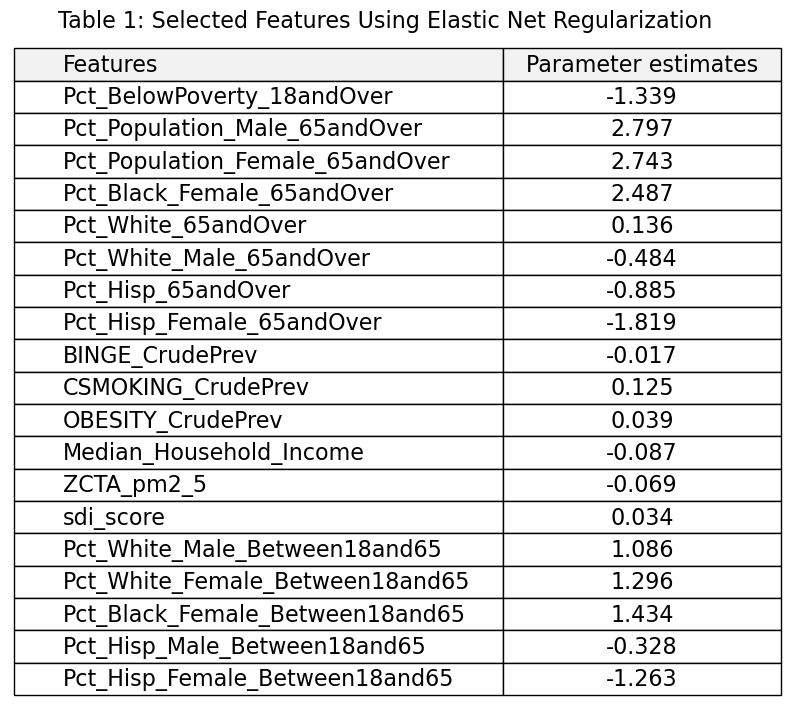

In [188]:


# Create a DataFrame from the table data
data = {
    "Features": [
         "Pct_BelowPoverty_18andOver", "Pct_Population_Male_65andOver",
        "Pct_Population_Female_65andOver", "Pct_Black_Female_65andOver", 
        "Pct_White_65andOver", "Pct_White_Male_65andOver", "Pct_Hisp_65andOver", 
        "Pct_Hisp_Female_65andOver", "BINGE_CrudePrev", "CSMOKING_CrudePrev", 
        "OBESITY_CrudePrev", "Median_Household_Income", "ZCTA_pm2_5", "sdi_score", 
        "Pct_White_Male_Between18and65", "Pct_White_Female_Between18and65", 
        "Pct_Black_Female_Between18and65", "Pct_Hisp_Male_Between18and65", 
        "Pct_Hisp_Female_Between18and65"
    ],
    "Parameter estimates": [
         -1.338841, 2.797313, 2.743481, 2.487065, 0.135896, 
        -0.484058, -0.885328, -1.818826, -0.017242, 0.124637, 0.039213, 
        -0.086541, -0.069284, 0.033822, 1.085857, 1.295837, 1.433959, 
        -0.327576, -1.263435
    ]
}

# Create the DataFrame


df = pd.DataFrame(data)


# Round the 'Parameter estimates' column to 3 decimal places


df["Parameter estimates"] = df["Parameter estimates"].round(3)


# Create a figure and axis


fig, ax = plt.subplots(figsize=(10, 6))  


ax.axis('tight')


ax.axis('off')



# Create the table


table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["#f2f2f2"]*2)


# Left-align the features column




for (i, j), cell in table.get_celld().items():

    
    if (j == 0):  

        
        cell.set_text_props(ha = 'left')



caption = "Table 1: Selected Features Using Elastic Net Regularization"



fig.text(0.5, 1.08, caption, ha='center', va='center', fontsize = 16)


# Increase font size of table cells and column labels



table.auto_set_font_size(False)  # Disable automatic font size adjustment



table.set_fontsize(16)  # Set font size for table cells




column_width = 0.3  



table.auto_set_column_width([1]) 



table.auto_set_column_width([0]) 



# Increase the row height


row_height = 0.07 


for i in range(len(df) + 1): 

    
    table[(i, 0)].set_height(row_height)

    
    table[(i, 1)].set_height(row_height)


# Save the table as a PNG image


plt.savefig("../Results/Selected_features_parameter_estimates_glm.png", bbox_inches="tight", dpi = 300)




In [154]:

## Processing the data for the XGBoost with Poisson Loss model training



non_zero_features = non_zero_coef.index



new_features  =  non_zero_features[1:]




colnames = np.array(pd.Series(new_features))



colnames



array(['Pct_BelowPoverty_18andOver', 'Pct_Population_Male_65andOver',
       'Pct_Population_Female_65andOver', 'Pct_Black_Female_65andOver',
       'Pct_White_65andOver', 'Pct_White_Male_65andOver',
       'Pct_Hisp_65andOver', 'Pct_Hisp_Female_65andOver',
       'BINGE_CrudePrev', 'CSMOKING_CrudePrev', 'OBESITY_CrudePrev',
       'Median_Household_Income', 'ZCTA_pm2_5', 'sdi_score',
       'Pct_White_Male_Between18and65', 'Pct_White_Female_Between18and65',
       'Pct_Black_Female_Between18and65', 'Pct_Hisp_Male_Between18and65',
       'Pct_Hisp_Female_Between18and65'], dtype=object)

In [134]:


xtrainx = x_train.copy(deep = True)



xtestx = x_test.copy(deep = True)



xtestx



,Pct_Civilian_Unemployed,Pct_BelowPoverty_18andOver,Pct_Population_Male_65andOver,Pct_Population_Female_65andOver,Pct_Black_65andOver,Pct_Black_Male_65andOver,Pct_Black_Female_65andOver,Pct_White_65andOver,Pct_White_Male_65andOver,Pct_White_Female_65andOver,...,OBESITY_CrudePrev,Median_Household_Income,ZCTA_pm2_5,sdi_score,Pct_White_Male_Between18and65,Pct_White_Female_Between18and65,Pct_Black_Female_Between18and65,Pct_Black_Male_Between18and65,Pct_Hisp_Male_Between18and65,Pct_Hisp_Female_Between18and65
503,1.8,11.188463,20.537046,18.050721,4.574838,2.337146,2.237693,33.764296,18.199901,15.564396,...,36.7,52179.0,7.982785,26.0,22.774739,28.194928,4.127300,5.469915,0.447539,0.000000
283,0.0,14.055944,15.734266,16.503497,8.741259,6.153846,2.587413,23.496503,9.580420,13.916084,...,35.4,59882.0,7.552918,31.0,28.321678,30.069930,3.636364,5.734266,0.000000,0.000000
570,6.0,11.449659,16.748675,14.629069,0.529902,0.529902,0.000000,29.712339,16.218774,13.493565,...,34.7,66000.0,7.617609,26.0,32.172597,33.535201,1.324754,0.794852,0.000000,0.000000
362,3.9,14.330844,13.181944,15.120465,7.920244,2.935475,4.984769,20.022155,10.135696,9.886458,...,42.3,41611.0,6.765537,67.0,22.846857,26.613127,10.108003,10.301855,4.403212,3.904736
541,10.8,19.202419,13.785701,15.083069,2.706739,1.493373,1.213366,26.068695,12.292328,13.776367,...,37.3,33788.0,7.696925,70.0,28.290088,30.679485,4.741460,3.490760,1.717379,1.876050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,2.3,16.524217,11.644658,21.728691,15.606242,6.242497,9.363745,17.166867,5.162065,12.004802,...,42.9,41838.0,6.810487,60.0,23.169268,19.327731,12.725090,10.204082,8.523409,0.600240
13,3.9,2.133624,7.758159,9.562027,0.879003,0.450967,0.428036,16.204235,7.161966,9.042269,...,25.1,138687.0,7.782189,3.0,36.841703,35.817473,2.698158,2.224260,3.844684,2.973324
552,3.6,8.533189,9.365223,11.555245,1.280257,0.551622,0.728635,19.265602,8.438992,10.826610,...,31.0,58913.0,7.486481,32.0,37.160382,35.213239,1.226741,2.861024,0.946814,1.152643
4,5.6,8.663903,5.480546,6.089073,1.361579,0.893774,0.467805,8.739969,3.966835,4.773134,...,33.8,88207.0,8.080360,56.0,31.129959,29.057164,3.822310,4.446050,17.616856,14.152056


In [135]:


xtrain_selected = xtrainx[colnames]



xtest_selected = xtestx[colnames]



In [136]:


xtrain_selected.head()



xtest_selected.head()




,Pct_BelowPoverty_18andOver,Pct_Population_Male_65andOver,Pct_Population_Female_65andOver,Pct_Black_Female_65andOver,Pct_White_65andOver,Pct_White_Male_65andOver,Pct_Hisp_65andOver,Pct_Hisp_Female_65andOver,BINGE_CrudePrev,CSMOKING_CrudePrev,OBESITY_CrudePrev,Median_Household_Income,ZCTA_pm2_5,sdi_score,Pct_White_Male_Between18and65,Pct_White_Female_Between18and65,Pct_Black_Female_Between18and65,Pct_Hisp_Male_Between18and65,Pct_Hisp_Female_Between18and65
503,11.188463,20.537046,18.050721,2.237693,33.764296,18.199901,0.497265,0.497265,12.3,20.8,36.7,52179.0,7.982785,26.0,22.774739,28.194928,4.127300,0.447539,0.000000
283,14.055944,15.734266,16.503497,2.587413,23.496503,9.580420,0.000000,0.000000,16.7,20.4,35.4,59882.0,7.552918,31.0,28.321678,30.069930,3.636364,0.000000,0.000000
570,11.449659,16.748675,14.629069,0.000000,29.712339,16.218774,1.116578,1.116578,16.5,20.1,34.7,66000.0,7.617609,26.0,32.172597,33.535201,1.324754,0.000000,0.000000
362,14.330844,13.181944,15.120465,4.984769,20.022155,10.135696,1.633896,0.000000,13.8,19.3,42.3,41611.0,6.765537,67.0,22.846857,26.613127,10.108003,4.403212,3.904736
541,19.202419,13.785701,15.083069,1.213366,26.068695,12.292328,0.326675,0.102669,14.1,26.0,37.3,33788.0,7.696925,70.0,28.290088,30.679485,4.741460,1.717379,1.876050


In [142]:


# Save the organized data 


# Save the files 



xtrain_selected.to_csv('../Data/xtrain_features_selected.csv', index = False)



xtest_selected.to_csv('../Data/xtest_features_selected.csv', index = False)



N_train.to_csv('../Data/Ntrain.csv', index = False)



N_test.to_csv('../Data/Ntest.csv', index = False)



y_train.to_csv('../Data/ytrain.csv', index = False)



y_test.to_csv('../Data/ytest.csv', index = False)


